# 1. Installation de art et imports

In [ ]:
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.3 MB 4.2 MB/s 
     |████████████████████████████████| 3.3 MB 44.9 MB/s 
     |████████████████████████████████| 34.5 MB 13 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


In [ ]:
from art.attacks.evasion import *
from art.estimators.classification import TensorFlowV2Classifier

import numpy as np
from math import pi
from random import random, randint

import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from tensorflow.keras.losses import MSE
from tensorflow.keras.losses import categorical_crossentropy as CCE
from tensorflow.keras.models import load_model

import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 2. Generate data like for a confusion matrix

In [ ]:
def conf_matrix(pred0, pred1, n_classes=5):
    """ Creates the n_classes*n_classes confusion matrix of pred1 compared to the original pred0. 
        - cmat[i,j] = nb of pts classified as i at the origin and as j after the attack """
    cmat = np.zeros((n_classes,n_classes)).astype(int)
    n_sample = pred0.shape[0]
    for k in range(n_sample):
        cmat[pred0[k],pred1[k]] += 1
    return(cmat)

In [ ]:
def norm_rows(cmat):
    """ Normalizes the lines of the confusion matrix cmat. """
    n = cmat.shape[0]
    ncmat = np.zeros((n,n))
    sum_rows = np.sum(cmat, axis=1)
    for k in range(n):
        s = sum_rows[k]
        if s != 0:
            ncmat[k,:] = cmat[k,:]/sum_rows[k]
    return(ncmat)

In [21]:
def load_attack(method, acas_model,iter=20,epsilon=0.3,etap=0.95):
    """ Choose your attack with 'method'. """
    
    if method == "nf":
        return(NewtonFool(classifier = acas_model, 
                          eta = etap, 
                          max_iter = iter,
                          verbose = True))
    
    elif method == "fgsm":
        return(FastGradientMethod(estimator = acas_model,
                                  eps = epsilon))
    
    elif method == "cw":
        return(CarliniLInfMethod(classifier = acas_model,
                                 initial_const = 1.0, 
                                 max_iter = iter, 
                                 verbose = True))

    elif method == "Deepfool":
        return DeepFool(classifier=acas_model, max_iter=iter)

    elif method == "ws":
        return Wasserstein(estimator= acas_model, targeted = False, regularization= 3000.0, p= 2, kernel_size= 5, eps_step= 0.1, norm = 'wasserstein', ball = 'wasserstein', eps = 0.3, eps_iter = 10, eps_factor= 1.1, max_iter= 400, conjugate_sinkhorn_max_iter= 400, projected_sinkhorn_max_iter= 400)
    
    elif method == "auto-pgd":
        return AutoProjectedGradientDescent(estimator= acas_model, norm = 1, eps = 0.3, eps_step = 0.1, max_iter = 100, targeted  = False, nb_random_init = 5, batch_size = 32)
    
    else:
        raise Exception("'{0}' is not a valid attack.".format(method))

In [ ]:
def generate_adv_data(N, method="fgsm", num_net=(1, 1), folder="/content/"):
    """Do not forget to set folder and, if you use Colab, to import your neural networks!"""
    # 1 - Load the model ACAS
    if (num_net[0] in range(1,6)) and (num_net[1] in range(1,10)):
        path_model = folder + "ACASXU_{}_{}.h5".format(num_net[0], num_net[1])
        model = load_model(path_model)
        model.compile()
    else:
        raise Exception("ACAS neural network {0}-{1} doesn't exist.".format(num_net[0],num_net[1]))

    # 2 - Transform into art form
    
    ACAS_classifier = TensorFlowV2Classifier(model = model,
                                             loss_object = MSE,
                                             train_step = None,
                                             nb_classes = 5,
                                             input_shape = (1, 5),
                                             clip_values = (-1.0, 1.0))

    attack = load_attack(method, ACAS_classifier)

    # 3 - Apply the attack on N random points
    
    #base_pts = np.random.rand(N, 5) - 0.5 # correction apportée le 12 mai

    inputs_boundaries = np.array([[-0.32842288, -0.5, -0.5, -0.5, -0.5],
                              [ 0.67985777,  0.5,  0.5,  0.5,  0.5]])

 

    def create_random_pts(npts, bounds=inputs_boundaries):
        """ Generate npts random points in the domain defined by bound. """
        pts = np.random.rand(npts, 5)
        for f in range(0,5):
            pts[:,f] *= (bounds[1][f] - bounds[0][f])
            pts[:,f] += bounds[0][f]
        return(pts)

    base_pts = create_random_pts(N)
    adv_pts = attack.generate(base_pts)
    
    base_pred = model.predict(base_pts)
    adv_pred = model.predict(adv_pts)
    
    return base_pts, adv_pts, base_pred, adv_pred   

# 3. Plot

In [27]:
def plot_adv_data(base_pts, adv_pts, base_pred, adv_pred, original_class= "WL", adv_class = "COC", dim1 = 0, dim2 = 1, show_lines=False, show_others=False):

    """
    Params:
    base_pts, adv_pts, base_pred, adv_pred: use the outputs of the generate_adv_data function
    original_class, dv_class: to select only the points that go from the original class to the adv class after the attack
    dim1, dim2: choose the two dimensions that are plotted in the graph. 0 corresponds to rho, 1 to theta, 2 to psi, 3 to vown, 4 to vint.
    show_lines: plot - or not - the graph with lines connected an original point and its adversarial version. Default is False.
    show_others: plot - or not - al the points on which the attack was performed. Default is False.
    """
    
    alabels = [r'$\rho$', "$\Theta$", "$\psi$", "$v_{own}$", "$v_{int}$"]
    class_dict = {"COC":0, "coc":0, "CoC":0, "WR":1, "wr":1, "SR":2, "sr":2, "WL":3, "wl":3, "SL":4, "sl":4}
    base_advice = np.argmin(base_pred, axis=1)
    adv_advice = np.argmin(adv_pred, axis=1)

    plt.figure(figsize=(20,10))

    if original_class not in class_dict.keys():
      raise Exception("Output " + original_class + " is unknown. The output should be in the list [COC, WR, SR, WL, SL].")
    if adv_class not in class_dict.keys():
      raise Exception("Output " + adv_class + " is unknown. The output should be in the list [COC, WR, SR, WL, SL].")

    int_base_advice = class_dict[original_class]
    int_adv_advice = class_dict[adv_class]

    list_diff_base = []
    list_diff_adv = []
    for i in range(len(base_advice)):
      if base_advice[i] == int_base_advice and adv_advice[i] == int_adv_advice: 
        list_diff_base.append(base_pts[i])
        list_diff_adv.append(adv_pts[i])
    array_diff_base = np.array(list_diff_base)
    array_diff_adv = np.array(list_diff_adv)

    if show_others:
      plt.scatter(base_pts[:, dim1], base_pts[:, dim2], color="lightsteelblue", label="All original points", alpha=0.5, zorder=3)
    if len(array_diff_base) > 0:
      plt.scatter(array_diff_base[:, dim1], array_diff_base[:, dim2], label="Original (" + original_class.upper() + ")", color="mediumblue", zorder=2)
      plt.scatter(array_diff_adv[:, dim1], array_diff_adv[:, dim2], label="Adversarial (" + adv_class.upper() + ")", color="red", zorder=2)
      if show_lines:
        for i in range(len(array_diff_base)):
          plt.plot([array_diff_base[i, dim1], array_diff_adv[i, dim1]],
                   [array_diff_base[i, dim2], array_diff_adv[i, dim2]],
                   color="black", zorder=1, linewidth=0.8, alpha=0.4)
      
    else:
      print("No data found.")

    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.xlabel(alabels[dim1] + " - normalized", fontsize = 15)
    plt.ylabel(alabels[dim2] + " - normalized", fontsize = 15)
    plt.show()

In [30]:
# Attention, cette cellule peut prendre du temps à s'exécuter
base_pts, adv_pts, base_pred, adv_pred = generate_adv_data(5000, "fgsm", (1, 7))

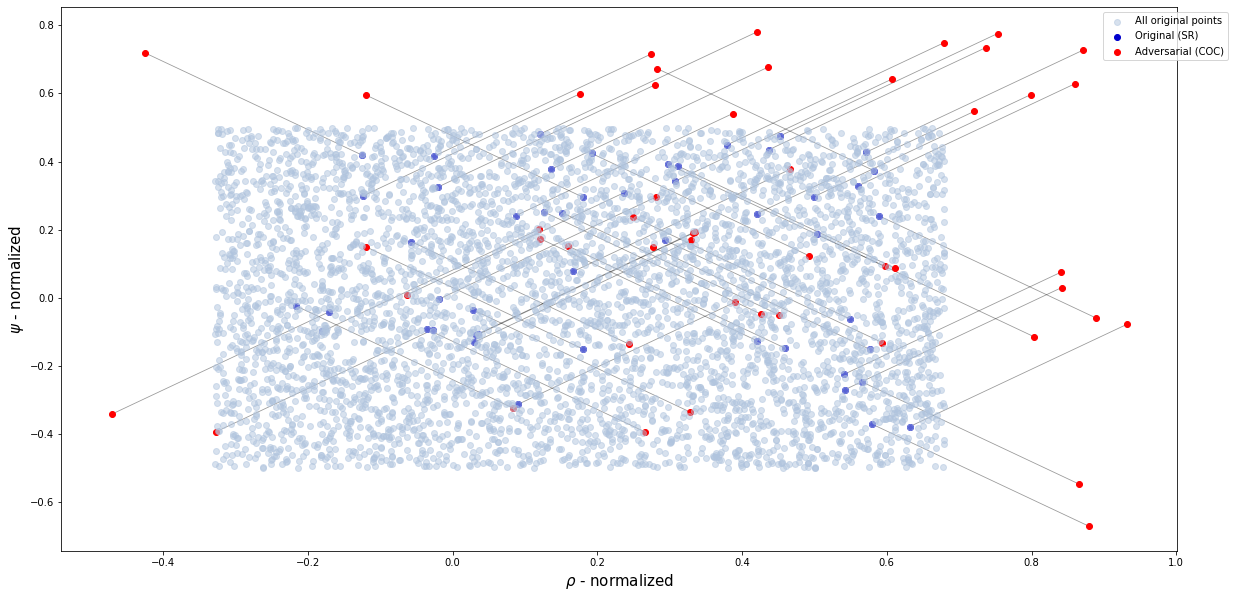

In [36]:
plot_adv_data(base_pts, adv_pts, base_pred, adv_pred, "sr", "coc", 0, 2, True, True)

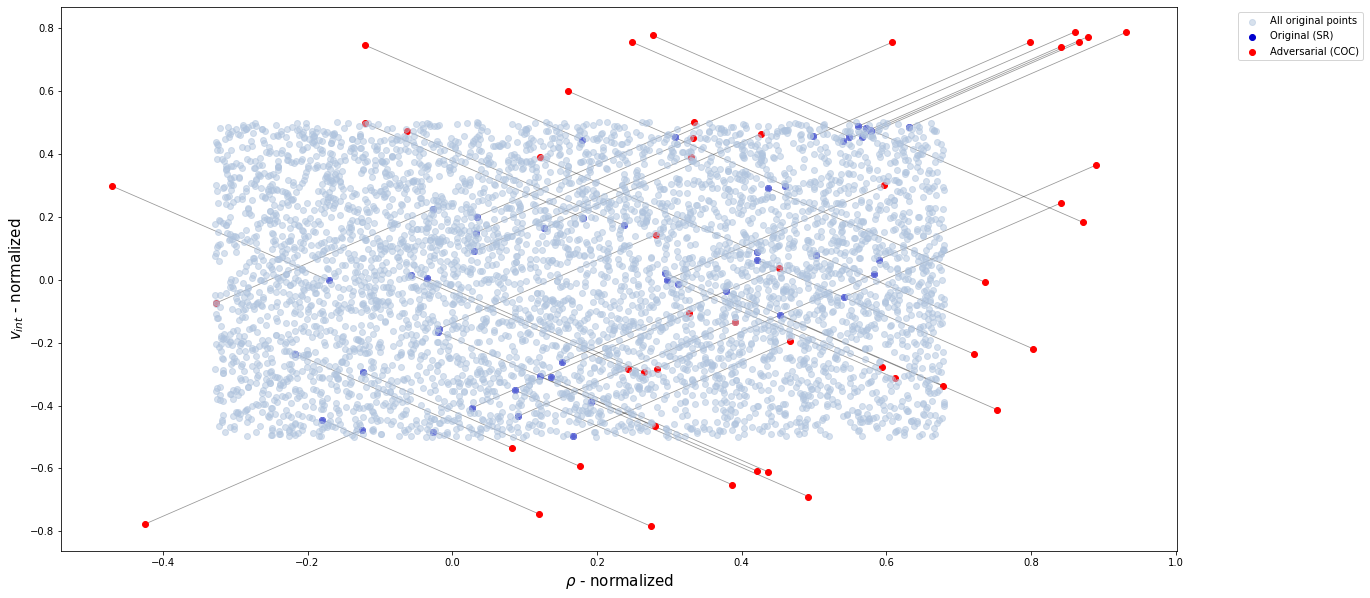

In [35]:
plot_adv_data(base_pts, adv_pts, base_pred, adv_pred, "sr", "coc", 0, 4, True, True)

# 4. 3D plot

In [28]:
def plot_adv_data_3d(base_pts, adv_pts, base_pred, adv_pred, original_class= "WL", adv_class = "COC", dim1 = 0, dim2 = 1, dim3 = 2, show_lines=False, show_others=True):

    """
    Params:
    base_pts, adv_pts, base_pred, adv_pred: use the outputs of the generate_adv_data function
    original_class, dv_class: to select only the points that go from the original class to the adv class after the attack
    dim1, dim2, dim3: choose the two dimensions that are plotted in the graph. 0 corresponds to rho, 1 to theta, 2 to psi, 3 to vown, 4 to vint.
    show_lines: plot - or not - the graph with lines connected an original point and its adversarial version. Default is False.
    show_others: plot - or not - al the points on which the attack was performed. Default is False. Not recommended in 3D.
    """
    
    alabels = [r'$\rho$', "$\Theta$", "$\psi$", "$v_{own}$", "$v_{int}$"]
    class_dict = {"COC":0, "coc":0, "CoC":0, "WR":1, "wr":1, "SR":2, "sr":2, "WL":3, "wl":3, "SL":4, "sl":4}
    base_advice = np.argmin(base_pred, axis=1)
    adv_advice = np.argmin(adv_pred, axis=1)

    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(projection='3d')

    if original_class not in class_dict.keys():
      raise Exception("Output " + original_class + " is unknown. The output should be in the list [COC, WR, SR, WL, SL].")
    if adv_class not in class_dict.keys():
      raise Exception("Output " + adv_class + " is unknown. The output should be in the list [COC, WR, SR, WL, SL].")

    int_base_advice = class_dict[original_class]
    int_adv_advice = class_dict[adv_class]

    list_diff_base = []
    list_diff_adv = []
    for i in range(len(base_advice)):
      if base_advice[i] == int_base_advice and adv_advice[i] == int_adv_advice: 
        list_diff_base.append(base_pts[i])
        list_diff_adv.append(adv_pts[i])
    array_diff_base = np.array(list_diff_base)
    array_diff_adv = np.array(list_diff_adv)

    if show_others:
      ax.scatter(base_pts[:, dim1], base_pts[:, dim2], base_pts[:, dim3], color="lightsteelblue", label="All original points", alpha=0.5, zorder=3)
    if len(array_diff_base) > 0:
      ax.scatter(array_diff_base[:, dim1], array_diff_base[:, dim2], array_diff_base[:, dim3], label="Original (" + original_class.upper() + ")", color="mediumblue", zorder=2)
      ax.scatter(array_diff_adv[:, dim1], array_diff_adv[:, dim2], array_diff_adv[:, dim3], label="Adversarial (" + adv_class.upper() + ")", color="red", zorder=2)
      if show_lines:
        for i in range(len(array_diff_base)):
          ax.plot([array_diff_base[i, dim1], array_diff_adv[i, dim1]],
                  [array_diff_base[i, dim2], array_diff_adv[i, dim2]],
                  [array_diff_base[i, dim3], array_diff_adv[i, dim3]],
                  color="black", zorder=1, linewidth=0.8, alpha=0.4)
      
    else:
      print("No data found.")

    ax.legend(bbox_to_anchor=(1.05, 1))
    ax.set_xlabel(alabels[dim1] + " - normalized", fontsize = 15)
    ax.set_ylabel(alabels[dim2] + " - normalized", fontsize = 15)
    ax.set_zlabel(alabels[dim3] + " - normalized", fontsize = 15)
    plt.show()

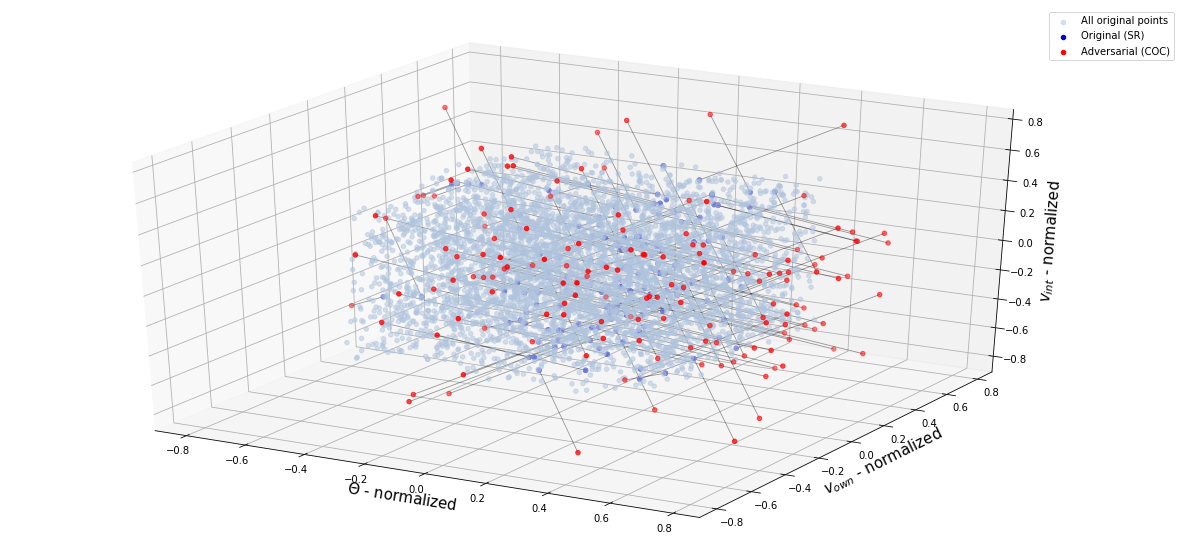

In [29]:
plot_adv_data_3d(base_pts, adv_pts, base_pred, adv_pred, "sr", "COC", 1, 3, 4, True, True)